# Dessler 2020 Journal of Climate figures

## this notebook contains figures 1-7

In [1]:
%pylab inline

import cartopy.crs as ccrs

import os,glob
from scipy import stats
import xarray as xr
import pandas as pd

Populating the interactive namespace from numpy and matplotlib


/Users/dessler/opt/anaconda3/lib/python3.7/site-packages/IPython/core/magics/pylab.py:160: UserWarning: pylab import has clobbered these variables: ['draw_if_interactive']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


In [2]:
import ols
from xradd import *

In [3]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=RuntimeWarning)

In [4]:
covar=lambda x,y,v='ens': ((x-x.mean(dim=v))*(y-y.mean(dim=v))).mean(dim=v) 
corr=lambda x,y,v='ens': covare(x,y,v)/x.std(dim=v)/y.std(dim=v)
slope=lambda x,y,v='ens': covar(x,y,v)/x.std(dim=v)**2

# global avg. for lat-only dataarray
def gavglat(x):
    ll=np.cos(np.deg2rad(x.lat)).where(x > -999e9)
    x1=(x*ll).sum(dim='lat')/ll.sum(dim='lat')

    return x1

In [5]:
def plotSinLat(datax,ax,**kwargs):
    """plotSinLat(datax): line plot vs. sin(latitude)
    datax is an xarray"""
    
    sca(ax)
    
    xlat=[-80,-50,-30,-15,0,15,30,50,80]
    xloc=[np.sin(np.deg2rad(ii)) for ii in xlat]
    xlab=[str(ii) for ii in xlat]

    plot(np.sin(np.deg2rad(datax.lat)),datax,**kwargs)
    xticks(xloc,xlab)

In [6]:
## define functions to estimate differences between hi/low ensemble members
def hilo(var,lim1=10):
    """return indices pointing to the high and low ensemble members of variable var"""
    var1=np.array(var)
    indhi=np.where(var1 >= np.percentile(var1,100-lim1))[0]
    indlo=np.where(var1 <= np.percentile(var1,lim1))[0]
    
    return indlo,indhi

diffe=lambda x: x.isel(ens=indhi).mean(dim='ens')-x.isel(ens=indlo).mean(dim='ens')

In [7]:
## make plots pretty
def colorplot(ax):
    
    almost_black = '#262626' # tweek from Thorsten
    
    for spx in ['top','right']:
            ax.spines[spx].set_visible(False)

    # Only show ticks on the left and bottom spines
    ax.yaxis.set_ticks_position('left')
    ax.xaxis.set_ticks_position('bottom')
        
    for spx in ['bottom','left']:
        ax.spines[spx].set_linewidth(0.5)
        ax.spines[spx].set_color(almost_black)
    
    for ticks in ax.xaxis.get_ticklines() + ax.yaxis.get_ticklines():
        ticks.set_color(almost_black)

def colorplotRight(ax):
    
    almost_black = '#262626' # tweek from Thorsten
    
    for spx in ['top','left']:
            ax.spines[spx].set_visible(False)

    # Only show ticks on the left and bottom spines
    ax.yaxis.set_ticks_position('right')
    ax.xaxis.set_ticks_position('bottom')
    
    # set axis positions
#     ax.yaxis.set_label_position(pspines[0]) 
#     ax.xaxis.set_label_position(pspines[1]) 
    
    for spx in ['bottom','right']:
        ax.spines[spx].set_linewidth(0.5)
        ax.spines[spx].set_color(almost_black)
    
    for ticks in ax.xaxis.get_ticklines() + ax.yaxis.get_ticklines():
        ticks.set_color(almost_black)
    
    ax.yaxis.set_label_position('right')

## load data

In [8]:
# this cell creates a single fluxes_all file, which contains the fluxes broken down into feedbacks
# for all of the ensembles

filepath='/sn1/dessler/MPI-feedback/{}{:04d}.nc'

diff=lambda x: x.sel(time=slice('1996-01-01','2005-12-31')).mean(dim='time')-x.sel(time=slice(None,'1859-12-31')).mean(dim='time')
fn='difference.nc'

# diff=lambda x: x.sel(time=slice('1996-01-01','2005-12-31')).mean(dim='time')-\
#         x.sel(time=slice('1859-01-01','1881-12-31')).mean(dim='time')
# fn='difference-1859-1881.nc'

# diff=lambda x: x.sel(time=slice('1986-01-01','1995-12-31')).mean(dim='time')-\
#         x.sel(time=slice('1865-01-01','1874-12-31')).mean(dim='time')
# fn='difference-1865-1995.nc'

# diff=lambda x: x.sel(time=slice('2000-01-01','2005-12-31')).mean(dim='time')-\
#         x.sel(time=slice('1860-01-01','1880-12-31')).mean(dim='time')
# fn='difference-1860-1880_2000-2005.nc'

if False:
    ens=[]

    forcing=xr.open_dataset('/home/dessler/energyBalance/historical/global/forcing_ens_components_90x45.nc')
    forcing['time']=pd.to_datetime(forcing.time,format='%Y%m%d.%f')
    forcing=diff(forcing)
    forcing['lat']=np.round(forcing.lat,2)
    print('global avg. forcing = {:.2f} W/m2/K'.format(float(gavg(forcing.f))))

    # read in each ensemble members fields, calculate difference between base and end periods
    for ii in range(1,101):
        
        try:
            x1=xr.open_dataset(filepath.format('fluxes',ii),chunks={'time':120})
            x2=xr.open_dataset(filepath.format('model',ii),chunks={'time':120})
        except FileNotFoundError:
            break

        x2['time']=x1.time
        x2=x2.drop('temp2,t,q,srads,sradsu'.split(','))
        x1['lat']=np.round(x1.lat,2)
        x2['lat']=np.round(x2.lat,2)

        x1=xr.merge([x1,x2])
        x1=x1.drop('plev')

        x1.expand_dims('ens')
        x1['ens']=[ii]

        ens.append(diff(x1))
        print(ii,end=" ")
    
    # combine individual ensemble members
    fluxes=xr.concat(ens,dim='ens');ens=[]
    fluxes['lat']=np.round(fluxes.lat,2)
    
    # subtract forcing from the fluxes
    for ii in 'trad0,srad0,traf0,sraf0'.split(','):
        fluxes[ii] -= forcing[ii]

    fluxes=fluxes.rename({'traf0':'lwcs','sraf0':'swcs','trad0':'lw','srad0':'sw'})
    fluxes=fluxes.assign(crfsw=fluxes.sw-fluxes.swcs,crflw=fluxes.lw-fluxes.lwcs)

    # load sea ice
    seaice=xr.open_dataarray('/sn1/dessler/MPI-historical/seaice_hist_merged_90x45.nc', chunks={'time': 120})

    # seaice is the change in percent coverage of sea ice
    seaice=diff(seaice)*100
    seaice['ens']=range(1,101)
    seaice['lat']=np.round(seaice.lat,2)

    fluxes=xr.merge([fluxes,seaice]) 
    
    fluxes.to_netcdf('/sn1/dessler/MPI-feedback/test_{}'.format(fn))

In [9]:
# ensdrop=[25,52,83] # ensemble members to drop b/c there's something weird with them
ensdrop=[] # drop no ensemble members

### read in the full 2D flux fields

then zonal and global average fiels

In [10]:
# load files and define additional fluxes
print('analysis of {}'.format(fn))
fluxes_diff=xr.open_dataset('../data/{}'.format(fn))
fluxes_diff=fluxes_diff.drop(ensdrop,dim='ens') 

analysis of difference.nc


/Users/dessler/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: DeprecationWarning: dropping labels using list-like labels is deprecated; using dict-like arguments with `drop_sel`, e.g. `ds.drop_sel(dim=[labels]).
  after removing the cwd from sys.path.


In [11]:
fluxes_diff=fluxes_diff.assign(cloud=fluxes_diff.cloudlw+fluxes_diff.cloudsw,\
    alltemp=fluxes_diff.planckRH+fluxes_diff.lapserateRH,\
    alllw=fluxes_diff.planckRH+fluxes_diff.lapserateRH+fluxes_diff.watervaporRH,
    resid=fluxes_diff.total-(fluxes_diff.planckRH+fluxes_diff.lapserateRH+\
    fluxes_diff.watervaporRH+fluxes_diff.albedo+fluxes_diff.cloudlw+fluxes_diff.cloudsw),\
    crf=fluxes_diff.crflw+fluxes_diff.crfsw)

# these dictionaries are for plotting labels
flab={'planckRH':'Planck','lapserateRH':'lapse rate','watervaporRH':'$\Delta$RH','cloud':'total cloud',\
    'cloudsw':'SW cloud','cloudlw':'LW cloud','albedo':'albedo','total':'total',\
    'resid':'residual','alltemp':'Planck+lapse rate','alllw':'Planck+lapse rate+$\Delta$RH',\
    'sw':'all-sky SW', 'lw':'all-sky LW', 'swcs':'clear-sky SW','lwcs':'clear-sky LW', 'crfsw':'SW CRF', \
    'crflw':'LW CRF', 'crf':'CRF', 'alllw':'planck+LR+$\Delta$RH', 'temperature':'temperature'}

flabx={'planckRH':'$\lambda_{Planck}$','lapserateRH':'$\lambda_{lapse\ rate}$','watervaporRH':'$\lambda_{\Delta RH}$',\
    'cloud':'$\lambda_{cloud}$','cloudsw':'$\lambda_{SW\ cloud}$','cloudlw':'$\lambda_{LW\ cloud}$',\
    'albedo':'$\lambda_{albedo}$','total':'$\lambda_{hist}$','resid':'residual','alllw':'$\lambda_{Planck+lapse\ rate+$\Delta$RH}$',\
    'sw':'$\lambda_{all\ sky\ SW}$', 'lw':'$\lambda_{all\ sky\ LW}$', 'swcs':'$\lambda_{clear\ sky\ SW}$','lwcs':'$\lambda_{clear\ sky\ LW}$', \
    'crfsw':'$\lambda_{SW\ CRF}$', 'crflw':'$\lambda_{LW\ CRF}$', 'crf':'$\lambda_{CRF}$'}

fluxes_diff

<xarray.Dataset>
Dimensions:       (ens: 100, lat: 45, lon: 90)
Coordinates:
  * lon           (lon) float64 0.0 4.0 8.0 12.0 ... 344.0 348.0 352.0 356.0
  * lat           (lat) float64 -90.0 -85.91 -81.82 -77.73 ... 81.82 85.91 90.0
  * ens           (ens) int64 1 2 3 4 5 6 7 8 9 ... 92 93 94 95 96 97 98 99 100
Data variables:
    planck        (ens, lat, lon) float32 ...
    lapserate     (ens, lat, lon) float32 ...
    planckRH      (ens, lat, lon) float32 ...
    lapserateRH   (ens, lat, lon) float32 ...
    watervapor    (ens, lat, lon) float64 ...
    watervaporRH  (ens, lat, lon) float64 ...
    albedo        (ens, lat, lon) float32 ...
    total         (ens, lat, lon) float64 ...
    cloudsw       (ens, lat, lon) float64 ...
    cloudlw       (ens, lat, lon) float64 ...
    temperature   (ens, lat, lon) float32 ...
    t500          (ens, lat, lon) float32 ...
    sw            (ens, lat, lon) float32 ...
    lw            (ens, lat, lon) float32 ...
    swcs          (ens, lat, lon) float32 ...
    lwcs          (ens, lat, lon) float32 ...
    crflw         (ens, lat, lon) float32 ...
    crfsw         (ens, lat, lon) float32 ...
    seaice        (ens, lat, lon) float32 ...
    cloud         (ens, lat, lon) float64 -0.04933 -0.04933 ... 1.589 1.589
    alltemp       (ens, lat, lon) float32 -1.1229955 -1.1229955 ... -3.8710306
    alllw         (ens, lat, lon) float64 -1.102 -1.102 -1.102 ... -4.01 -4.01
    resid         (ens, lat, lon) float64 0.7805 0.7805 0.7805 ... -0.304 -0.304
    crf           (ens, lat, lon) float32 0.064641416 0.064641416 ... -1.2305403

In [12]:
# set temperature to use when calculating feedbacks
# reftemp=fluxes_diff.t500.sel(lat=slice(-30,30))
# reftemp=fluxes_diff.t500 
reftemp=fluxes_diff.temperature

In [13]:
# ts=gavg(reftemp.sel(lat=slice(-30,30)))
ts=gavg(reftemp)
zfdb=fluxes_diff.mean(dim='lon')/ts # zonal average feedbacks
gfdb=gavg(fluxes_diff)/ts # global average feedbacks

In [14]:
# find the ensemble members with the highest and lowest ECS values
indlo,indhi=hilo(gfdb.total,lim1=10)

#### load indices

In [15]:
# load indices 
enso=xr.open_dataset('../data/enso.nc')
enso=enso.rename({'__xarray_dataarray_variable__':'enso'})
enso=diff(enso).to_array(name='ENSO').squeeze()
enso=enso.drop('variable')

index=xr.open_dataset('../data/MPI_indices_1850_2020.nc')
index['time']=pd.date_range('1850-07-01',freq='A',periods=len(index.time))
index=index.rename({'member':'ens'})
index['ens']=range(1,101)

index=index.drop(ensdrop,dim='ens')
index=diff(index)

index=xr.merge([index,enso])

vars=list(index.keys())#;vars.remove('ens')
signIndex={}
for ii in vars:
    xx=index[ii]
    fit1=stats.linregress(gfdb.total,xx)

    # sign for plots later
    signIndex[ii]=1
    if fit1.slope < 0: signIndex[ii]=-1

index

/Users/dessler/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: DeprecationWarning: dropping labels using list-like labels is deprecated; using dict-like arguments with `drop_sel`, e.g. `ds.drop_sel(dim=[labels]).
  if sys.path[0] == '':


<xarray.Dataset>
Dimensions:  (ens: 100)
Coordinates:
  * ens      (ens) int64 1 2 3 4 5 6 7 8 9 10 ... 91 92 93 94 95 96 97 98 99 100
Data variables:
    PDO      (ens) float32 -1.1549807 -3.0309954 ... 1.4125353 -0.22716728
    SPDO     (ens) float32 -1.559893 -2.4060094 ... 2.0963902 1.0837646
    IPO      (ens) float32 -1.4566615 -2.7239962 ... 1.8751795 0.49782634
    TPI      (ens) float32 -1.1737723 -3.2284079 ... 1.5341831 0.86210173
    AMO      (ens) float32 -0.61486745 0.5409212 ... -1.6462743 0.78387856
    SAMO     (ens) float32 -0.4429459 1.555013 ... -3.1778579 -1.6581784
    IOD      (ens) float32 -1.5347626 -1.1274664 ... -1.1547878 2.131182
    ENSO     (ens) float64 -0.03425 -0.8648 -0.1675 ... 0.02389 0.5046 0.1605

load land-ocean mask

### summary of feedbacks

average & 5-95% range: -1.43 & -1.64 to -1.18
uncertainty +/-: -0.18 -0.15


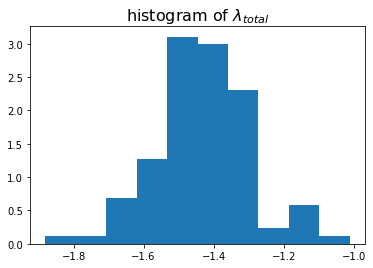

In [16]:
hist(gfdb.total,density=True)
title('histogram of $\lambda_{total}$',fontsize=16)
x1=np.array(gfdb.total)
mean1,perc5,perc95=x1.mean(),np.percentile(x1,5),np.percentile(x1,95)
print('average & 5-95% range: {:.2f} & {:.2f} to {:.2f}'.format(mean1,perc5,perc95))
print('uncertainty +/-: {:.2f} {:.2f}'.format((perc95-mean1)/mean1,(mean1-perc5)/mean1))

## Figure 1

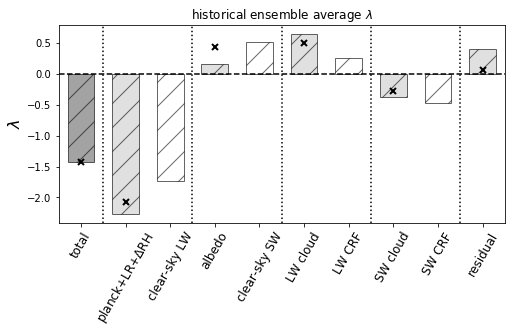

In [17]:
fig=figure(figsize=(8,5))
plt.subplots_adjust(bottom=0.33)

nvarx='total,alllw,lwcs,albedo,swcs,cloudlw,crflw,cloudsw,crfsw,resid'.split(',')

# flabx={'planckRH':'$\lambda_{Planck}$','lapserateRH':'$\lambda_{lapse\ rate}$','watervaporRH':'$\lambda_{\Delta RH}$','cloud':'$\lambda_{cloud}$',\
#      'cloudsw':'$\lambda_{SW\ cloud}$','cloudlw':'$\lambda_{LW\ cloud}$','albedo':'$\lambda_{albedo}$','total':'$\lambda_{hist}$',\
#      'resid':'residual','alllw':'$\lambda_{Planck+lapse\ rate+\Delta RH}$',\
#      'sw':'all-sky SW', 'lw':'all-sky LW', 'swcs':'$\lambda_{clear\ sky\ SW}$','lwcs':'$\lambda_{clear\ sky\ LW}$', 'crfsw':'$\lambda_{SW\ CRF}$', \
#       'crflw':'$\lambda_{LW\ CRF}$', 'crf':'CRF'}

fb=[float(gfdb[ii].mean(dim='ens')) for ii in nvarx]
fb_ceppi=[-1.42,-2.07,np.nan,0.44,np.nan,0.50,np.nan,-0.28,np.nan,0.07]

h1=(['','/']*len(nvarx))[:len(nvarx)]
c1=(['0.4']+['0.8','w']*len(nvarx))[:len(nvarx)]

barx=plt.bar(range(len(nvarx)),fb,alpha=0.6,color=c1,hatch='/',edgecolor='black',width=0.6)
plot(range(len(nvarx)),fb_ceppi,'kx',markersize=6,mew=2)
     
xticks(range(len(nvarx)),[flab[ll] for ll in nvarx],rotation=60,fontsize=12);

for ii in np.arange(0.5,10,2): axvline(ii,color='k',ls='dotted')
xlim(-0.5,len(nvarx)-0.5)

#     axvline(0.5,color='k',ls='dotted')
#     xlim(-0.5,len(nvarx)-0.5)

axhline(0,color='k',ls='dashed')

title('historical ensemble average $\lambda$')
#     ylim(-2.4,0.8)

ylabel('$\lambda$',fontsize=16);

savefig('../figures/fig1.pdf')

In [18]:
## estimate uncertainty in each average feedback
for ii in 'total,alllw,lwcs,albedo,swcs,cloudlw,crflw,cloudsw,crfsw,resid'.split(','):
    d1=[]
    for jj in range(1000):
        ind1=np.random.randint(100,size=100)
        d1.append(gfdb[ii].isel(ens=ind1).mean())
    # print correlation coefficient and 5-95% confidence interval
    print('{}: {:.2f} vs. {:.2f} to {:.2f}'.format(ii,float(gfdb[ii].mean()),np.percentile(d1,5),np.percentile(d1,95)))

total: -1.43 vs. -1.45 to -1.41
alllw: -2.27 vs. -2.28 to -2.26
lwcs: -1.74 vs. -1.74 to -1.73
albedo: 0.17 vs. 0.15 to 0.18
swcs: 0.52 vs. 0.50 to 0.54
cloudlw: 0.65 vs. 0.63 to 0.66
crflw: 0.27 vs. 0.25 to 0.28
cloudsw: -0.38 vs. -0.40 to -0.36
crfsw: -0.47 vs. -0.49 to -0.45
resid: 0.40 vs. 0.39 to 0.41


output stats of residual

In [19]:
# hist(gfdb.resid)
print('mean residual: {:.2f}'.format(np.array(np.mean(gfdb.resid))))
print('5-95 percentile: {:.2f}-{:.2f}'.format(np.percentile(gfdb.resid,5),np.percentile(gfdb.resid,95)))

mean residual: 0.40
5-95 percentile: 0.31-0.50


In [20]:
## check on correlations with residual
## use monte carlo bootstrap technique to estimate uncertainty
## the results show that all of the feedbacks with exception of cloudsw have
## statistically significant correlations (5-95% CI)
for ii in 'planckRH,lapserateRH,watervaporRH,albedo,cloudsw,cloudlw,total'.split(','):
    z1=stats.linregress(gfdb['resid'],gfdb[ii])
    d1=[]
    for jj in range(1000):
        ind1=np.random.randint(100,size=100)
        d1.append(stats.linregress(gfdb['resid'],gfdb[ii][ind1]).rvalue)
    # print correlation coefficient and 5-95% confidence interval
    print(ii,z1.rvalue,np.percentile(d1,5),np.percentile(d1,95))

planckRH -0.2579709480217728 -0.16400571479016043 0.1698369322534287
lapserateRH -0.27836994478246363 -0.17340913311295997 0.1543683951773042
watervaporRH -0.5472253832457561 -0.16538535308453822 0.16795327533115562
albedo -0.2450088020953561 -0.16045818606116893 0.15662701087979242
cloudsw 0.01640229754399042 -0.16316189293631678 0.16652870004099743
cloudlw -0.4289644950664247 -0.16153847367493057 0.16731272477446243
total -0.32736631110006337 -0.15790424299991032 0.1640806012798026


## Figure 2

In [21]:
lowval=zfdb.mean(dim='ens')-zfdb.std(dim='ens')
highval=zfdb.mean(dim='ens')+zfdb.std(dim='ens')

In [22]:
berk=xr.open_dataset('../data/Berkeley_90x45.nc')
berk['time']=pd.date_range('1850-01-01',freq='M',periods=len(berk.time))
berk=diff(berk)
berk=berk.mean(dim='lon').temperature
berk['lat']=np.round(berk.lat,2)

In [23]:
## load Berkeley temperature data for comparison to model
berk=xr.open_dataset('../data/Berkeley_90x45.nc') # processed with cdo -remapbil,r90x45 ifile ofile
berk['lat']=np.round(berk.lat,2)
berk['time']=pd.date_range('1850-01-01',freq='M',periods=len(berk.time))

# calculate masked temperature difference; use mask from first Berkeley month
# choice of mask (or even having a mask) doesn't make much of a difference
# x_comp=fluxes_diff.temperature.where(berk.temperature.isel(time=0) > -999).mean(dim='lon')
x_comp=fluxes_diff.temperature.mean(dim='lon')

# calculate temp difference for berkeley
berk=diff(berk)
berk=berk.mean(dim='lon').temperature
berk['lat']=np.round(berk.lat,2)

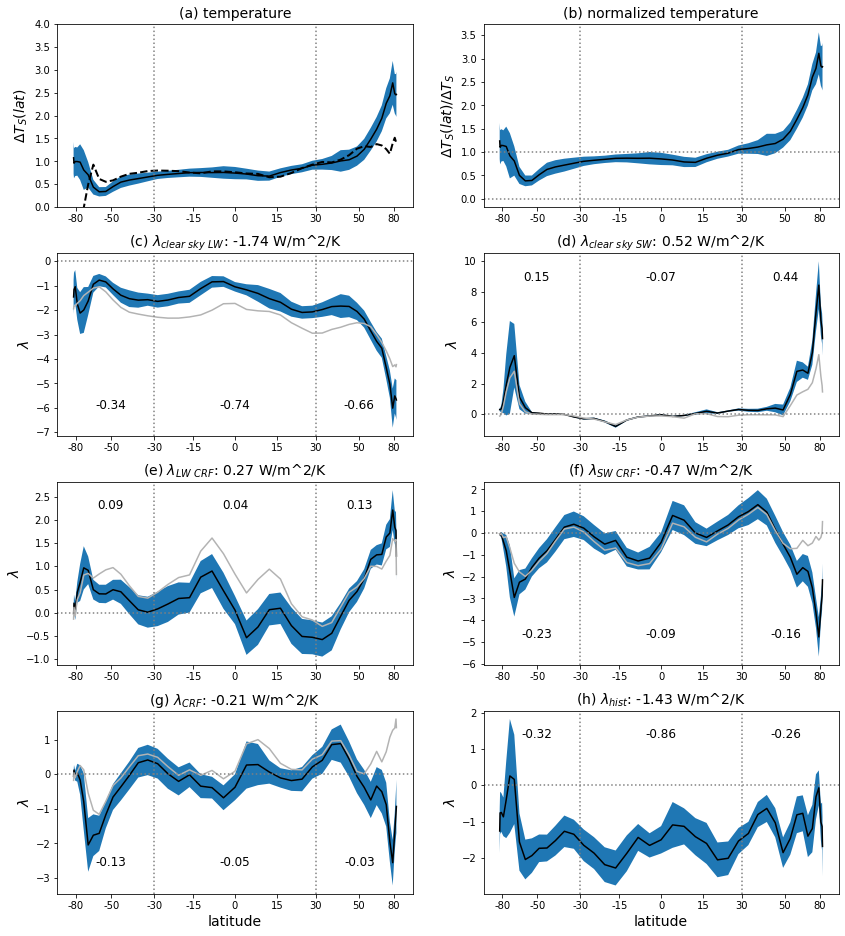

In [24]:
nvarx='temperature,lwcs,swcs,crflw,crfsw,crf,total'.split(',')
nvarx2='off,alllw,albedo,cloudlw,cloudsw,cloud,off'.split(',')

if len(nvarx)//2 != len(nvarx)/2: 
       nvarx.append('off')
       nvarx2.append('off')

fig=figure(figsize=(14,2*len(nvarx)))
plt.subplots_adjust(hspace=0.25)

panel=iter('bcdefghijkl')
axes=[]

# d1=diffe(zfdb)

vloc=iter([0.85,0.15,0.85,0.85,0.15,0.15,0.85,0.85])
for cnt,jj1 in enumerate(zip(nvarx,nvarx2)):
    jj=jj1[0]
    vloc1=next(vloc)
       
    if jj == 'off': continue
        
    ax1=fig.add_subplot(len(nvarx)//2,2,cnt+2)
    sca(ax1)
    axes.append(ax1)
    
    plotSinLat(zfdb[jj].mean(dim='ens'),ax1,color='k')
    
    ## calculate uncertainty in mean
    fill_between(np.sin(np.deg2rad(zfdb.lat)),lowval[jj],highval[jj])
    
#     plotSinLat(zfdb[jj].isel(ens=indlo).mean(dim='ens'),ax1,color='k',ls='dotted')
#     plotSinLat(zfdb[jj].isel(ens=indhi).mean(dim='ens'),ax1,color='k',ls='dashed')
#     plotSinLat(d1[jj],ax1,color='k',ls='dashed')
    
    if jj1[1] != 'off':
        plotSinLat(zfdb[jj1[1]].mean(dim='ens'),ax1,color='0.7')
    
    # put numbers on plot that show regional breakdown
    loc1=iter([0.15,0.5,0.85])
    if cnt > 0:
        for kk in [[-90,-30],[-30,30],[30,90]]:
            # avg1 is the average in the latitude range, setting values outside the latitude range to zero
            # so the sum of the latitude-range averages sum to the global average
            avg1=gavglat(zfdb[jj].mean(dim='ens').where((zfdb.lat >= kk[0]) & (zfdb.lat < kk[1]),0))
            text(next(loc1),vloc1,'{:.2f}'.format(float(avg1)),ha='center',transform=ax1.transAxes,fontsize=12)
    axvline(np.sin(np.deg2rad(-30)),color='0.5',ls=':')
    axvline(np.sin(np.deg2rad(30)),color='0.5',ls=':')

    if jj == 'temperature':
        axhline(1,color='0.5',ls='dotted')

    axhline(0,color='0.5',ls='dotted')
        
    if jj != 'temperature':
        title('({}) {}: {:.2f} W/m^2/K'.format(next(panel),flabx[jj],float(gavglat(zfdb[jj].mean(dim='ens')))),fontsize=14)
    else:
        title('({}) {}'.format(next(panel),flab[jj]),fontsize=14)

axes[0].set_ylabel('$\Delta T_S(lat)/\Delta T_S$',fontsize=14)
for ii in axes[1:]:
    ii.set_ylabel('$\lambda$',fontsize=14)

axes[-1].set_xlabel('latitude',fontsize=14)
axes[-2].set_xlabel('latitude',fontsize=14)

ax1=fig.add_subplot(len(nvarx)//2,2,1)
# for ii in range(100):
#     x1=x_comp.isel(ens=ii)
#     plotSinLat(x1,ax1,label='ensemble avg.',color='0.8')
plotSinLat(berk,ax1,label='Berkeley',lw=2,color='k',ls='dashed')
fill_between(np.sin(np.deg2rad(zfdb.lat)),x_comp.mean(dim='ens')-x_comp.std(dim='ens'),x_comp.mean(dim='ens')+x_comp.std(dim='ens'))
plotSinLat(x_comp.mean(dim='ens'),ax1,color='k')
ylim(0,4)
axvline(np.sin(np.deg2rad(-30)),color='0.5',ls=':')
axvline(np.sin(np.deg2rad(30)),color='0.5',ls=':')
ylabel('$\Delta T_S(lat)$',fontsize=14)
title('(a) temperature',fontsize=14)

axes[0].set_title('(b) normalized temperature',fontsize=14);
# legend()

savefig('../figures/fig2.pdf')

## Figure 3

In [25]:
## difference in residual between high and low ECS groups
diffe(gfdb.resid)

<xarray.DataArray 'resid' ()>
array(-0.08010896)

[0.4927734981693095, 0.02682778178957279, 0.46460307099281484, 0.04267536028935304, -0.015847578134402712, 0.2731536854724981, 0.19144938619632096]


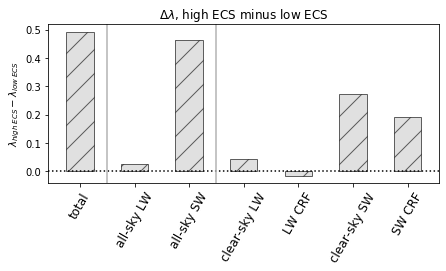

In [26]:
fig=figure(figsize=(7,4))
plt.subplots_adjust(bottom=0.33)

nvarx='total,lw,sw,lwcs,crflw,swcs,crfsw'.split(',')
# nvarx='total,albedo,cloudsw,alllw,cloudlw,resid'.split(',')

fb=[float(diffe(gfdb[ii])) for ii in nvarx]
fbfrac=np.array(fb)/fb[0]
print(fb)
barx=plt.bar(range(len(nvarx)),fb,alpha=0.6,width=0.5,color='0.8',hatch='/',edgecolor='black')
xticks(range(len(nvarx)),[flab[ll] for ll in nvarx],rotation=60,fontsize=12)

axhline(0,color='k',ls='dotted')
title('$\Delta \lambda$, high ECS minus low ECS')
ylabel('$\lambda_{high\ ECS} - \lambda_{low\ ECS}$')

# ax2=gca().twinx()
# # ax2.plot(np.linspace(10,20),np.linspace(0,1))
# ax2.bar(np.arange(len(nvarx))+10,fbfrac,alpha=0.6,width=0.5,color='0.8',hatch='/',edgecolor='black')

# xlim(-0.5,len(nvarx)-0.5)
# ylabel('fractional contribution');

axvline(0.5,color='0.7')
axvline(2.5,color='0.7')

savefig('../figures/fig3.pdf')

## Figure 4

In [27]:
## return difference of 'indhix' and 'indlox' subsets
diffe_mc1=lambda x,indhix,indlox: x.isel(ens=indhix).mean(dim='ens')-x.isel(ens=indlox).mean(dim='ens')

def diffe_mc(inp1,indhi,indlo):
    """do monte carlo estimate of the uncertainty in the differences of the 'indhi' and 'indlo' ensemble subsets"""

    output=[]
    for ii in range(1000):
        x1=np.random.randint(0,len(indhi),size=len(indhi)*2)
        d1=diffe_mc1(inp1,indhi[x1[:10]],indlo[x1[10:]])
        output.append(d1)
        
    output=xr.concat(output,dim='samples')
    return output

In [28]:
## d1 contains the MC samples of the difference
d1=diffe_mc(zfdb,indhi,indlo)

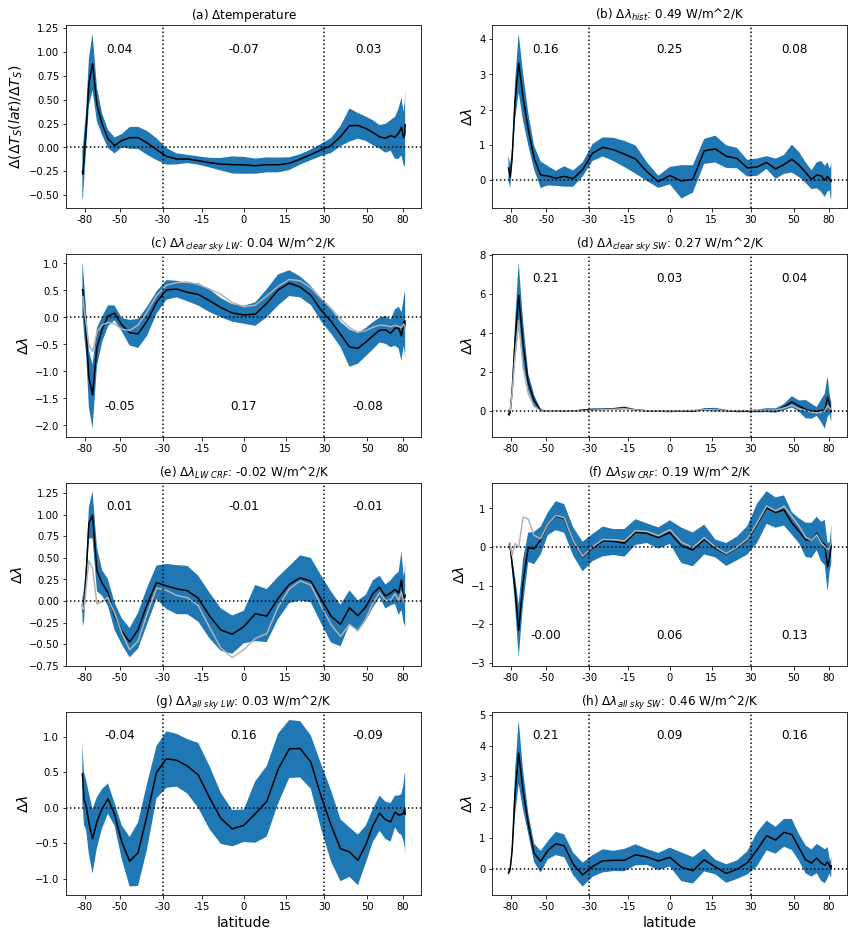

In [29]:
nvarx='temperature,total,lwcs,swcs,crflw,crfsw,lw,sw'.split(',')
nvarx2='off,off,alllw,albedo,cloudlw,cloudsw,off,off'.split(',')

if len(nvarx)//2 != len(nvarx)/2: 
       nvarx.append('off')
       nvarx2.append('off')

fig=figure(figsize=(14,2*len(nvarx)))
plt.subplots_adjust(hspace=0.25)

panel=iter('abcdefghijkl')
axes=[]

vloc=iter([0.85,0.85,0.15,0.85,0.85,0.15,0.85,0.85])
for cnt,jj1 in enumerate(zip(nvarx,nvarx2)):
    jj=jj1[0]
    vloc1=next(vloc)
       
    if jj == 'off': continue
        
    ax1=fig.add_subplot(len(nvarx)//2,2,cnt+1)
    sca(ax1)
    axes.append(ax1)
    
    plotSinLat(d1[jj].mean(dim='samples'),ax1,color='k')
    lowval=d1[jj].quantile(0.05,dim='samples')
    highval=d1[jj].quantile(0.95,dim='samples')
    fill_between(np.sin(np.deg2rad(zfdb.lat)),lowval,highval)
    
    if jj1[1] != 'off':
        plotSinLat(d1[jj1[1]].mean(dim='samples'),ax1,color='0.7')
    
#     plotSinLat(zfdb[jj].mean(dim='ens'),ax1,color=colors[1])
#     fill_between(np.sin(np.deg2rad(zfdb.lat)),low_mean[jj],high_mean[jj])
#     plotSinLat(zfdb[jj].mean(dim='ens'),ax1,color='k',ls='dashed')
    
    # put numbers on plot that show regional breakdown
    loc1=iter([0.15,0.5,0.85])
    for kk in [[-90,-30],[-30,30],[30,90]]:
        # avg1 is the average in the latitude range, setting values outside the latitude range to zero
        # so the sum of the latitude-range averages sum to the global average
        avg1=gavglat(d1[jj].mean(dim='samples').where((d1.lat >= kk[0]) & (d1.lat < kk[1]),0))
        text(next(loc1),vloc1,'{:.2f}'.format(float(avg1)),ha='center',transform=ax1.transAxes,fontsize=12)
    axvline(np.sin(np.deg2rad(-30)),color='k',ls=':')
    axvline(np.sin(np.deg2rad(30)),color='k',ls=':')

    axhline(0,color='k',ls='dotted')
        
    if jj != 'temperature':
        title('({}) $\Delta${}: {:.2f} W/m^2/K'.format(next(panel),flabx[jj],float(gavglat(d1[jj].mean(dim='samples')))),fontsize=12)
    else:
        title('({}) $\Delta${}'.format(next(panel),flab[jj]),fontsize=12)

axes[0].set_ylabel('$\Delta(\Delta T_S(lat)/\Delta T_S)$',fontsize=14)
for ii in axes[1:]:
    ii.set_ylabel('$\Delta \lambda$',fontsize=14)

axes[-1].set_xlabel('latitude',fontsize=14)
axes[-2].set_xlabel('latitude',fontsize=14)
   
savefig('../figures/fig4.pdf')

In [30]:
## print SW cloud feedback in various lat ranges
## print average over latitude range and fraction of global
print('lat range, average, fraction')
for kk in [[-90,-30],[-30,30],[30,90],[-90,90]]:
    # avg1 is the average in the latitude range, setting values outside the latitude range to zero
    # so the sum of the latitude-range averages sum to the global average
    avg1=gavglat(d1['cloudsw'].where((d1.lat >= kk[0]) & (d1.lat < kk[1]),0))
    
    avg2=avg1/gavglat(d1['cloudsw'])
    print(kk,float(np.average(avg1)),float(np.average(avg2)),\
        float(np.percentile(avg2,5)),float(np.percentile(avg2,95)))

lat range, average, fraction
[-90, -30] 0.08633902075080781 0.2677997042153319 0.12522232737757422 0.3993954956331837
[-30, 30] 0.08694607205376736 0.2757402986323125 0.12278430359121716 0.43019178741029784
[30, 90] 0.14528095240669056 0.45645999715235563 0.359822567324561 0.5574241831196384
[-90, 90] 0.31856604521126575 1.0 1.0 1.0


## Figure 5

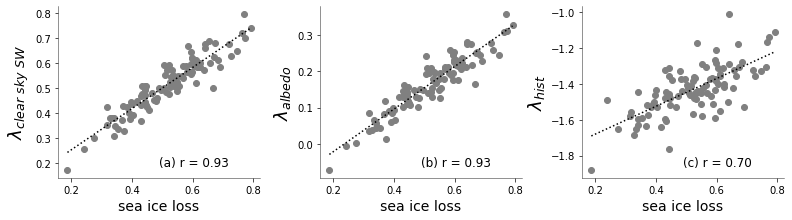

In [31]:
fig,axes=plt.subplots(1,3,figsize=(13,3.5))
plt.subplots_adjust(wspace=0.3,bottom=0.2)

labx=iter('(a),(b),(c),(d)'.split(','))

x=-gavg(fluxes_diff.seaice)#.sel(lat=slice(-90,-40)))
for ii,dd in enumerate('swcs,albedo,total'.split(',')):
    sca(axes[ii])
    
    # make scatterplot
    y=gfdb[dd]
    plot(x,y,'o',color='0.5')
#     ylabel('$\lambda_{'+flab[dd]+'}$',fontsize=18)
    ylabel(flabx[dd],fontsize=18)
    xlabel('sea ice loss',fontsize=14)
    colorplot(gca()) # make pretty
    
    # estimate fit
    fit1=stats.linregress(x,y)
    text(0.5,0.07,'{} r = {:.2f}'.format(next(labx),fit1.rvalue),fontsize=12,transform=gca().transAxes)
    
    # add dotted line
    x2=np.linspace(np.min(x),np.max(x))
    plot(x2,x2*fit1.slope+fit1.intercept,color='k',ls=':')

# ylim(-1.9,-0.95);
savefig('../figures/fig5.eps')

## Figure 6

LinregressResult(slope=0.06559765078038407, intercept=0.023615294172773044, rvalue=0.6320824592107722, pvalue=1.7550081380689875e-12, stderr=0.008123586432567005)
LinregressResult(slope=0.02744324698388047, intercept=0.28990288801364317, rvalue=0.5451208493324604, pvalue=4.519138835163715e-09, stderr=0.004263427729965892)


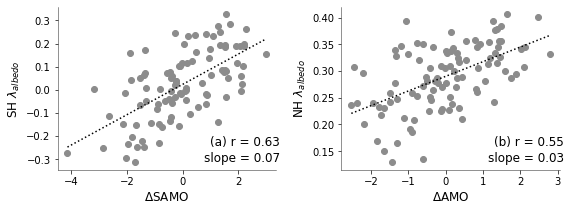

In [32]:
fig,axes=plt.subplots(1,2,figsize=(9,3))
plt.subplots_adjust(wspace=0.3)
labx=iter('abc')
var1='albedo'

for ii,dd in enumerate([[(None,0),index.SAMO,'SH,SAMO'],[(0,None),index.AMO,'NH,AMO']]):
    sca(axes[ii])
    
    # make scatterplot
    y=gavglat(zfdb[var1].sel(lat=slice(*dd[0])))
    x=dd[1]
    plot(x,y,'o',color='0.55')
    ylabel(dd[2].split(',')[0]+' {}'.format(flabx[var1]),fontsize=12)
    xlabel('$\Delta${}'.format(dd[2].split(',')[1]),fontsize=12)
    colorplot(gca()) # make pretty
    
    # estimate fit
    fit1=stats.linregress(x,y)
    print(fit1)
    text(0.7,0.15,'({}) r = {:.2f}'.format(next(labx),fit1.rvalue),fontsize=12,transform=gca().transAxes)
    text(0.67,0.05,'slope = {:.2f}'.format(fit1.slope),fontsize=12,transform=gca().transAxes)
    
    # add dotted line
    x2=np.linspace(np.min(x),np.max(x))
    plot(x2,x2*fit1.slope+fit1.intercept,color='k',ls=':')

savefig('../figures/fig6.eps')

In [33]:
## look at correlation between albedo feedback and AMO/SAMO from other hemisphere
var1='albedo'
for ii,dd in enumerate([[(None,0),index.AMO],[(0,None),index.SAMO]]):
   
    # make scatterplot
    y=gavglat(zfdb[var1].sel(lat=slice(*dd[0])))
    x=dd[1]
    
    # estimate fit
    fit1=stats.linregress(x,y)
    print(fit1)
 

LinregressResult(slope=0.008910378741437507, intercept=0.023362708438058183, rvalue=0.07340001264416784, pvalue=0.46799099976698344, stderr=0.01222964737194932)
LinregressResult(slope=-0.005467638595562773, intercept=0.28939337540274124, rvalue=-0.1270406130612525, pvalue=0.20783378919153117, stderr=0.004312320038716133)


In [34]:
## look at other indices
var1='swcs'
vars='PDO,SPDO,IPO,TPI,IOD'.split(',')

for ii in vars:
    for dd in [(None,0),(0,None)]:
   
        # make scatterplot
        y=gavglat(zfdb[var1].sel(lat=slice(*dd)))
        x=index[ii]
        print(ii,dd,stats.linregress(x,y))

PDO (None, 0) LinregressResult(slope=-0.03597924171850632, intercept=0.11865276044124497, rvalue=-0.21053790398854025, pvalue=0.03550626185039021, stderr=0.01687576663598788)
PDO (0, None) LinregressResult(slope=-0.005103849360711001, intercept=0.8775103135954596, rvalue=-0.05049387350612607, pvalue=0.6178436015029805, stderr=0.010197454349077213)
SPDO (None, 0) LinregressResult(slope=-0.06829011278112557, intercept=0.1204596336634681, rvalue=-0.37560777042712956, pvalue=0.00011770863761622607, stderr=0.0170210473145364)
SPDO (0, None) LinregressResult(slope=-0.009761523146761363, intercept=0.8777675599316579, rvalue=-0.09077303947851083, pvalue=0.36909275382177287, stderr=0.010818100776387066)
IPO (None, 0) LinregressResult(slope=-0.055871589772237405, intercept=0.1197480537260256, rvalue=-0.3113613378420273, pvalue=0.0016146995073485029, stderr=0.017225434876487974)
IPO (0, None) LinregressResult(slope=-0.010000144171118963, intercept=0.8776711009527357, rvalue=-0.09421986290982812, 

## Fig. 7

LinregressResult(slope=-0.8150525302633101, intercept=0.7391758290002344, rvalue=-0.6970875339481191, pvalue=7.897663542989008e-16, stderr=0.08468294263392197)
LinregressResult(slope=-1.0374581228442432, intercept=-0.008889172964392955, rvalue=-0.7732672686190901, pvalue=4.208702804098998e-21, stderr=0.08593540319010179)
LinregressResult(slope=1.4238229086729184, intercept=-1.955620358436955, rvalue=0.4574105343129819, pvalue=1.715556641061754e-06, stderr=0.2796168939210942)
LinregressResult(slope=-5.37643120730271, intercept=7.359238930394333, rvalue=-0.4572551042744255, pvalue=1.7312751725576583e-06, stderr=1.0563021403219717)


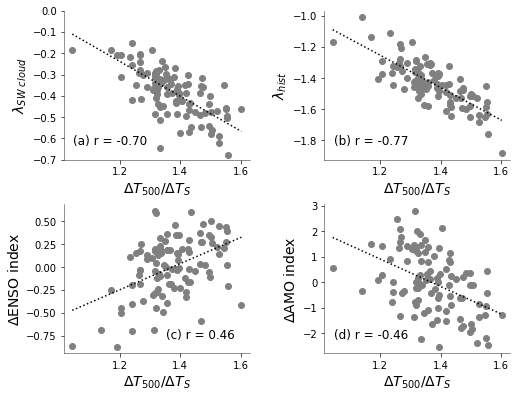

In [35]:
## four-panel version with correlation vs. lambda_hist

t500_m=gavg(fluxes_diff.t500.sel(lat=slice(-30,30)))/ts
# t500_m=gavg(fluxes_diff.t500)/ts

vx='cloudsw'
x2=gavg(fluxes_diff[vx])/ts#.sel(lat=slice(-30,30)))/t500_m
# x2=gavglat(zfdb[vx].sel(lat=slice(-60,60)))

x1=[t500_m,t500_m,t500_m,t500_m]
x2=[x2,gfdb.total,index.ENSO,index.AMO]
num_panels=len(x2)

fig,axes=plt.subplots(2,num_panels//2,figsize=(8,7))
axes=axes.reshape(size(axes))
plt.subplots_adjust(wspace=0.4,hspace=0.3,bottom=0.2)

labx=iter('abcdefghijkl')
xlabx=iter(['$\Delta T_{500}$/$\Delta T_S$','$\Delta T_{500}$/$\Delta T_S$','$\Delta T_{500}$/$\Delta T_S$','$\Delta T_{500}$/$\Delta T_S$',\
            '$\Delta T_A$','$\Delta T_A-\Delta T_S$','$\Delta T_{500}$/$\Delta T_S$'])
ylabx=iter([flabx[vx],flabx['total'],'$\Delta$ENSO index','$\Delta$AMO index'])
xx=iter(x1);x2=iter(x2)

for ii in range(num_panels):
    sca(axes[ii])
    a1=next(xx);b1=next(x2)
    plot(a1,b1,'o',color='0.5')
    y2=np.linspace(np.min(a1),np.max(a1))
    fit1=stats.linregress(a1,b1)
    print(fit1)
    plot(y2,y2*fit1.slope+fit1.intercept,color='k',ls=':')
#     plot(y2,y2*fit1.slope+fit1.intercept,color='k',ls=':')

    if ii != 2:
        text(0.05,0.1,'({}) r = {:.2f}'.format(next(labx),fit1.rvalue),fontsize=12,transform=gca().transAxes)
    else:
        text(0.55,0.1,'({}) r = {:.2f}'.format(next(labx),fit1.rvalue),fontsize=12,transform=gca().transAxes)
        
    xlabel(next(xlabx),fontsize=14)
    ylabel(next(ylabx),fontsize=14)
    colorplot(gca())

sca(axes[0])
ylim(-0.7,0)

savefig('../figures/fig7.eps')

In [36]:
## compare t500 metric to total cloud feedback
stats.linregress(t500_m,gfdb.cloud)

LinregressResult(slope=-0.06721011288378324, intercept=0.36047127808983237, rvalue=-0.0782015844672858, pvalue=0.43930381612250224, stderr=0.08655137983422036)

In [37]:
## compare ENSO to PDO
stats.linregress(index.ENSO,index.PDO)

LinregressResult(slope=2.7565139322358743, intercept=-0.020580256055970546, rvalue=0.7289276723804851, pvalue=8.147451135250792e-18, stderr=0.2615132641545959)

In [38]:
## calculate fraction of cloud feedback from each latitude range
d1=diffe(zfdb)
tot=0
varx='cloudsw'
# calculate regional breakdown
for kk in [[-90,-30],[-30,30],[30,90]]:
    # avg1 is the average in the latitude range, setting values outside the latitude range to zero
    # so the sum of the latitude-range averages sum to the global average
    avg1=gavglat(d1[varx].where((d1.lat >= kk[0]) & (d1.lat < kk[1]),0))
    tot += float(avg1)

for kk in [[-90,-30],[-30,30],[30,90]]:
    # avg1 is the average in the latitude range, setting values outside the latitude range to zero
    # so the sum of the latitude-range averages sum to the global average
    avg1=gavglat(d1[varx].where((d1.lat >= kk[0]) & (d1.lat < kk[1]),0))
    print(kk,'{:.2f}'.format(float(avg1)),'{:.2f}'.format(float(avg1)/tot))

print('{:.2f}'.format(tot))

[-90, -30] 0.09 0.27
[-30, 30] 0.09 0.28
[30, 90] 0.15 0.45
0.32
